In [1]:
!nvidia-smi

Tue Jul  4 04:23:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.47                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 L...    On | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P8               10W /  N/A|   1294MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/KnightChaser/ML-challenge/main/EX_challenging_problems/03_power_consumption_prediction/TetuanCityPowerConsumption.csv")             # UPLOADED
print(df)

# EDA Processes has been abbreviated as much as possible due to duplication.

       Temperature  Humidity  Wind Speed  general diffuse flows  \
0            6.559      73.8       0.083                  0.051   
1            6.414      74.5       0.083                  0.070   
2            6.313      74.5       0.080                  0.062   
3            6.121      75.0       0.083                  0.091   
4            5.921      75.7       0.081                  0.048   
...            ...       ...         ...                    ...   
52411        7.010      72.4       0.080                  0.040   
52412        6.947      72.6       0.082                  0.051   
52413        6.900      72.8       0.086                  0.084   
52414        6.758      73.0       0.080                  0.066   
52415        6.580      74.1       0.081                  0.062   

       diffuse flows  Zone 1 Power Consumption  
0              0.119               34055.69620  
1              0.085               29814.68354  
2              0.100               29128.10127  

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

train_dataset = df.sample(frac = 0.8, random_state = 0xCAFE)
test_dataset  = df.drop(train_dataset.index)

# The prdiction objective of the current model
train_target = train_dataset.pop("Zone 1 Power Consumption")
test_target  = test_dataset.pop("Zone 1 Power Consumption")

ss = StandardScaler()

ss.fit(train_dataset)
train_scaled = ss.transform(train_dataset)
test_scaled  = ss.transform(test_dataset)

print(train_scaled.shape)
print(train_target.shape)

(41933, 5)
(41933,)


In [5]:
from tensorflow import keras

def create_CNN_model(additional_layers = None):

    model = keras.Sequential()

    if additional_layers:
        for more_layer in additional_layers:
            model.add(more_layer)

    model.add(keras.layers.Dense(units = 1))        # regression

    return model

In [17]:
model = create_CNN_model([
    keras.layers.Conv1D(32, kernel_size = 2,                                    # Convolution (1D)
                            activation  = "relu",
                            padding     = "same",
                            input_shape = (train_scaled.shape[1], 1)),
    keras.layers.MaxPooling1D(pool_size = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 1024, activation = "relu"),
    keras.layers.Dense(units = 512),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units = 128),
    keras.layers.Dense(units = 64),
    keras.layers.Dense(units = 32),
    keras.layers.Dense(units = 16),
])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 5, 32)             96        
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 32)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 1024)              66560     
                                                                 
 dense_27 (Dense)            (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

In [18]:
from sklearn.utils import validation

model.compile(loss = "mse",            # <--- REGRESSION
              metrics = "mae",
              optimizer = "adam")

early_stopping_checkpoint = keras.callbacks.EarlyStopping(patience = 16, restore_best_weights = True, mode = "auto")
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only = True)


history = model.fit(train_scaled, train_target,
                    epochs = 1000,
                    steps_per_epoch = 200,
                    validation_data = (test_scaled, test_target),
                    callbacks = [early_stopping_checkpoint, checkpoint_cb])

Epoch 1/1000
200/200 [==============================] - 4s 11ms/step - loss: 199477984.0000 - mae: 10417.0107 - val_loss: 57625816.0000 - val_mae: 6458.5078
Epoch 2/1000
200/200 [==============================] - 2s 9ms/step - loss: 49968452.0000 - mae: 5902.6094 - val_loss: 43515884.0000 - val_mae: 5399.1138
Epoch 3/1000
200/200 [==============================] - 2s 9ms/step - loss: 43320968.0000 - mae: 5353.1836 - val_loss: 46059420.0000 - val_mae: 5322.2358
Epoch 4/1000
200/200 [==============================] - 2s 10ms/step - loss: 41944664.0000 - mae: 5241.5527 - val_loss: 40273220.0000 - val_mae: 5159.0376
Epoch 5/1000
200/200 [==============================] - 2s 10ms/step - loss: 41190136.0000 - mae: 5181.2549 - val_loss: 39743692.0000 - val_mae: 5121.7490
Epoch 6/1000
200/200 [==============================] - 2s 9ms/step - loss: 40467760.0000 - mae: 5110.3066 - val_loss: 39763076.0000 - val_mae: 5146.9043
Epoch 7/1000
200/200 [==============================] - 2s 10ms/step - 

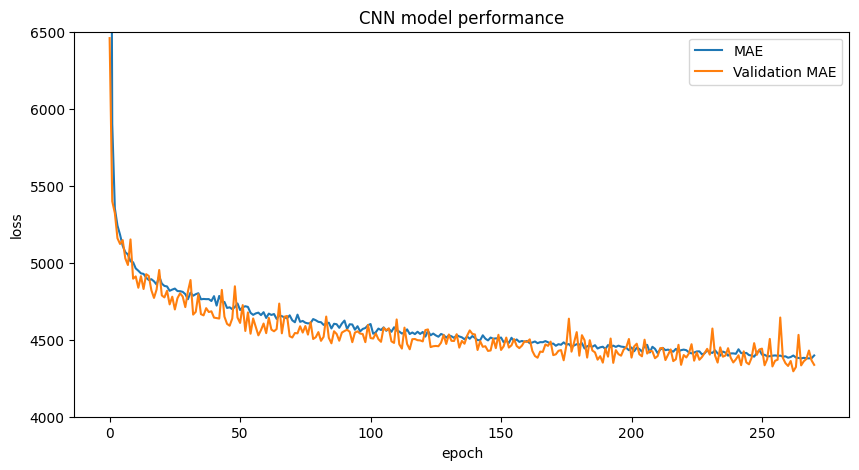

In [20]:
import matplotlib.pyplot as plt

plt.title("CNN model performance")

plt.plot(history.history["mae"], label = "MAE")
plt.plot(history.history["val_mae"], label = "Validation MAE")

# plt.ylim([min(min(history.history["mae"]), min(history.history["val_mae"])) - 1000, max(max(history.history["mae"]), max(history.history["val_mae"])) + 1000])
plt.ylim([4000, 6500])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.show()

In [ ]:
model.evaluate(test_scaled, test_target)

119/328 [=========>....................] - ETA: 1s - loss: 36304588.0000 - mae: 4530.2124